In [1]:
from qiskit import IBMQ, QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit_textbook.tools import array_to_latex
import numpy as np

In [2]:
IBMQ.save_account('ae34492536f3cd754603c73df73f55825b197ca309e786e19806ee5ba431e32b79e5a913567179b45a31157956ad160a95dfd402fd3452594d42ea80ef08df7a')
IBMQ.load_account()

configrc.store_credentials:WARNING:2021-04-21 13:32:33,600: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
#IBMQ.load_accounts()

def check_result(results, col, row):
    wins=0
    losses=0
   
    for i in results: 
        x=i
        print(results)
        print("Quantum circuit solution")
        print(i+"\n")
        i=[int(char) for char in i]
        print("Reversing Array to get x bits first and changing 0's to 1's")
        i=np.array(list(reversed(i)))
        i=np.where(i==0,-1,i)
        # bring array in correct i.e. from incoming y2,y1,x2,x1 -> x1,x2,y1,y2
        a = i[0:2]
        
        a_prod = np.prod(a)
        a3 = 1*int(a_prod)
        a = np.append(a,a3)
        winning_alice = int(np.prod(a)) == 1
        # compute x3 by x1*x2

        b = i[2:]
        b_prod = np.prod(b)
        b3 = -1*int(b_prod)
        b = np.append(b,b3)
        winning_bob = int(np.prod(b)) == -1
        # compute y3 by negating y1*y2

        # compute overall winning condition -> alice at index of bob's row and vice versa
        
        print("Alice's selection. Column:"+str(col)+"\n"+str(a.reshape(3,1))+"\n")
        print("Bob's circuit solution. Row:"+str(row)+"\n"+str(b)+"\n")
        
        if(winning_bob & winning_alice & (a[row-1]==b[col-1])):
            print("Victory!")    
            print("The following magic square wins the game!")
            k = np.empty((3,3,))
            k[:] = np.nan
            k[:,col-1] = a
            k[row-1,:] = b
            print(k)
            wins+=results.get(x)
        else:
            print("The Game is lost!")
            losses+=results.get(x)
        print("------------------------------------------")  
        print("\n")
    return (wins,losses)

def makeEntangleCircuit():
    qr=QuantumRegister(4,name="qr")
    cr=ClassicalRegister(4,name="cr")
    EPRpair = QuantumCircuit(qr, cr, name="entangle")
#     print(qr[0])
    for i in range(2):
        EPRpair.h(qr[i])
    #vect=sv(EPRpair)
    #array_to_latex(vect, pretext="\\text{Statevector} = ")
    EPRpair.cx(qr[0],qr[2])
    EPRpair.cx(qr[1],qr[3])
    return EPRpair
    
def Alice(qc,col):
    if col==1:
        qc.h(0)
        qc.i(1)
    elif col==2:
        qc.swap(0,1)
        qc.h(0)
        qc.i(1)
    elif col==3:
        qc.cx(0,1)
        qc.h(0)
        qc.i(1)
        
def Bob(qc,row):
    if row==1:
        qc.h(2)
        qc.h(3)
    if row==2:
        qc.swap(2,3)
    elif row==3:
        qc.z(2)
        qc.z(3)
        qc.cz(2,3)
        qc.h(2)
        qc.h(3)
        
# print("Alice choice (column):")
# alice = int(input())
# print("Bob choice (row):")
# bob = int(input())
results=dict()
for alice in [1,2,3]:
    for bob in [1,2,3]:
        #Draw the rest of the circuit based on Alice and Bob's selection
        circuit=makeEntangleCircuit()
        if 4>alice>0 and 4>bob>0:
            Alice(circuit,alice) 
            Bob(circuit,bob)
            circuit.barrier()
            circuit.measure(0,0)
            circuit.measure(1,1)
            circuit.measure(2,2)
            circuit.measure(3,3)

            circuit.draw(output='mpl')
            print(circuit)

            provider = IBMQ.get_provider(hub='ibm-q')

            backend = provider.get_backend('ibmq_santiago') # define the backend
            #backend = BasicAer.get_backend('qasm_simulator')
            job = execute(circuit, backend, shots=8192) # run the job simulation
            results[(alice,bob)] = (job.result().get_counts(),check_result(job.result().get_counts(), alice, bob))
            print(results)

# #Draw the rest of the circuit based on Alice and Bob's selection
# circuit=makeEntangleCircuit()
# if 4>alice>0 and 4>bob>0:
#     Alice(circuit,alice) 
#     Bob(circuit,bob)
#     circuit.barrier()
#     circuit.measure(0,0)
#     circuit.measure(1,1)
#     circuit.measure(2,2)
#     circuit.measure(3,3)
    
#     circuit.draw(output='mpl')
#     print(circuit)
    
#     provider = IBMQ.get_provider(hub='ibm-q')
    
#     backend = provider.get_backend('ibmq_quito') # define the backend
#     job = execute(circuit, backend, shots=8192) # run the job simulation
#     results = job.result().get_counts()
#     check_result(results, alice, bob)
#     print(results)

      ┌───┐     ┌───┐      ░ ┌─┐         
qr_0: ┤ H ├──■──┤ H ├──────░─┤M├─────────
      ├───┤  │  └───┘┌───┐ ░ └╥┘┌─┐      
qr_1: ┤ H ├──┼────■──┤ I ├─░──╫─┤M├──────
      └───┘┌─┴─┐  │  ├───┤ ░  ║ └╥┘┌─┐   
qr_2: ─────┤ X ├──┼──┤ H ├─░──╫──╫─┤M├───
           └───┘┌─┴─┐├───┤ ░  ║  ║ └╥┘┌─┐
qr_3: ──────────┤ X ├┤ H ├─░──╫──╫──╫─┤M├
                └───┘└───┘ ░  ║  ║  ║ └╥┘
cr: 4/════════════════════════╩══╩══╩══╩═
                              0  1  2  3 
{'0000': 928, '0001': 31, '0010': 802, '0011': 29, '0100': 29, '0101': 1039, '0110': 41, '0111': 1269, '1000': 931, '1001': 25, '1010': 733, '1011': 33, '1100': 24, '1101': 1136, '1110': 30, '1111': 1112}
Quantum circuit solution
0000

Reversing Array to get x bits first and changing 0's to 1's
Alice's selection. Column:1
[[-1]
 [-1]
 [ 1]]

Bob's circuit solution. Row:1
[-1 -1 -1]

Victory!
The following magic square wins the game!
[[-1. -1. -1.]
 [-1. nan nan]
 [ 1. nan nan]]
------------------------------------------


{'0000': 9

In [4]:
import pprint
provider = IBMQ.get_provider(hub='ibm-q')
for backend in provider.backends():
    status = backend.status().to_dict()
    if status['operational'] and status['status_msg']=='active':
        print( pprint.pformat(backend.status().to_dict()) )

{'backend_name': 'ibmq_qasm_simulator',
 'backend_version': '0.1.547',
 'operational': True,
 'pending_jobs': 27,
 'status_msg': 'active'}
{'backend_name': 'ibmqx2',
 'backend_version': '2.3.5',
 'operational': True,
 'pending_jobs': 1,
 'status_msg': 'active'}
{'backend_name': 'ibmq_16_melbourne',
 'backend_version': '2.3.18',
 'operational': True,
 'pending_jobs': 17017,
 'status_msg': 'active'}
{'backend_name': 'ibmq_armonk',
 'backend_version': '2.4.6',
 'operational': True,
 'pending_jobs': 4,
 'status_msg': 'active'}
{'backend_name': 'ibmq_athens',
 'backend_version': '1.3.16',
 'operational': True,
 'pending_jobs': 6044,
 'status_msg': 'active'}
{'backend_name': 'ibmq_santiago',
 'backend_version': '1.3.19',
 'operational': True,
 'pending_jobs': 1957,
 'status_msg': 'active'}
{'backend_name': 'ibmq_lima',
 'backend_version': '1.0.8',
 'operational': True,
 'pending_jobs': 67,
 'status_msg': 'active'}
{'backend_name': 'ibmq_belem',
 'backend_version': '1.0.8',
 'operational': Tr

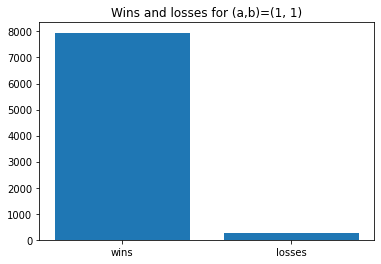

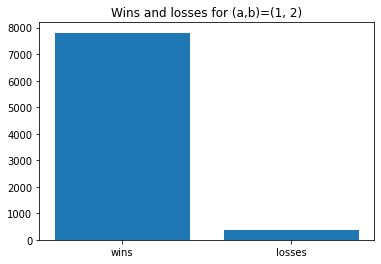

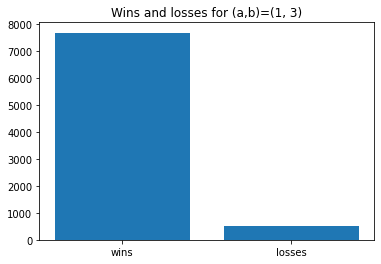

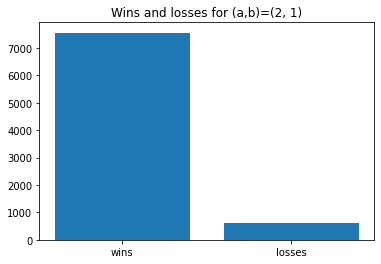

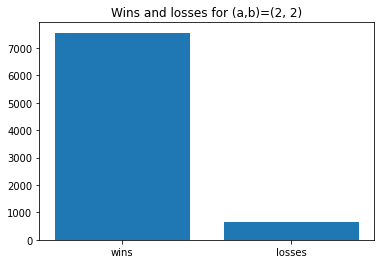

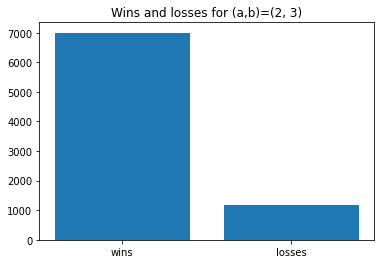

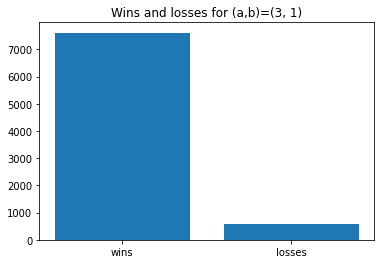

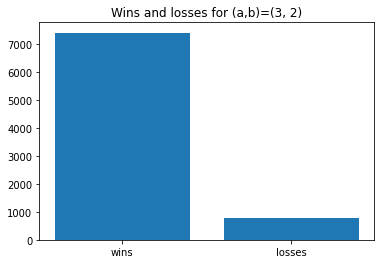

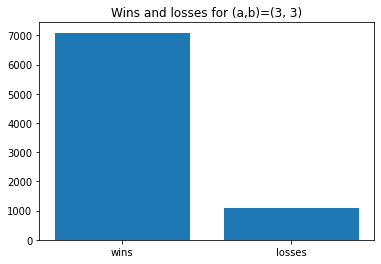

In [5]:
import matplotlib.pyplot as plt
for a in [1,2,3]:
    for b in [1,2,3]:
        plt.title("Wins and losses for (a,b)="+str((a,b)))
        plt.bar([0,1],[results.get((a,b))[1][0],results.get((a,b))[1][1]],tick_label=["wins","losses"])
        plt.savefig("plot"+str(a)+str(b)+"santiagoreal",dpi=300)
        plt.show()